In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
from torch.utils.tensorboard.summary import image
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train=datasets.MNIST(root=r'D:Machine Learning\assignment 2', train=True, transform=transform, download=True)
test_data=datasets.MNIST(root=r'D:Machine Learning\assignment 2', train=False, transform=transform, download=True)



In [3]:
train_images = train.data.numpy()
train_labels = train.targets.numpy()

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

train_images = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)  
val_images = torch.tensor(val_images, dtype=torch.float32).unsqueeze(1)
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)

train_data = TensorDataset(train_images, train_labels)
val_data = TensorDataset(val_images, val_labels)
test_dataset = TensorDataset(torch.tensor(test_data.data.numpy(), dtype=torch.float32).unsqueeze(1), torch.tensor(test_data.targets.numpy(), dtype=torch.long))



In [4]:
print(len(train_data))
print(len(val_data))
print(len(test_dataset))

48000
12000
10000


In [5]:
train_loader=torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)
val_loader=torch.utils.data.DataLoader(dataset=val_data, batch_size=64, shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [6]:
train_batch = next(iter(train_loader))
x_train, y_train = train_batch
val_batch = next(iter(val_loader))
x_val, y_val = val_batch
test_batch = next(iter(test_loader))
x_test, y_test = test_batch


In [7]:
for images, labels in train_loader:
    print(f"Image batch dimensions: {images.shape}")  
    print(f"Label batch: {labels}")  
    break  


Image batch dimensions: torch.Size([64, 1, 28, 28])
Label batch: tensor([8, 4, 2, 4, 6, 3, 0, 0, 2, 0, 6, 9, 6, 9, 6, 9, 1, 9, 7, 6, 4, 0, 1, 6,
        1, 7, 6, 3, 8, 4, 9, 6, 9, 0, 2, 4, 4, 1, 5, 7, 1, 8, 8, 5, 7, 0, 3, 0,
        8, 7, 4, 0, 5, 1, 8, 8, 8, 2, 4, 9, 5, 4, 0, 7])


sample of training data


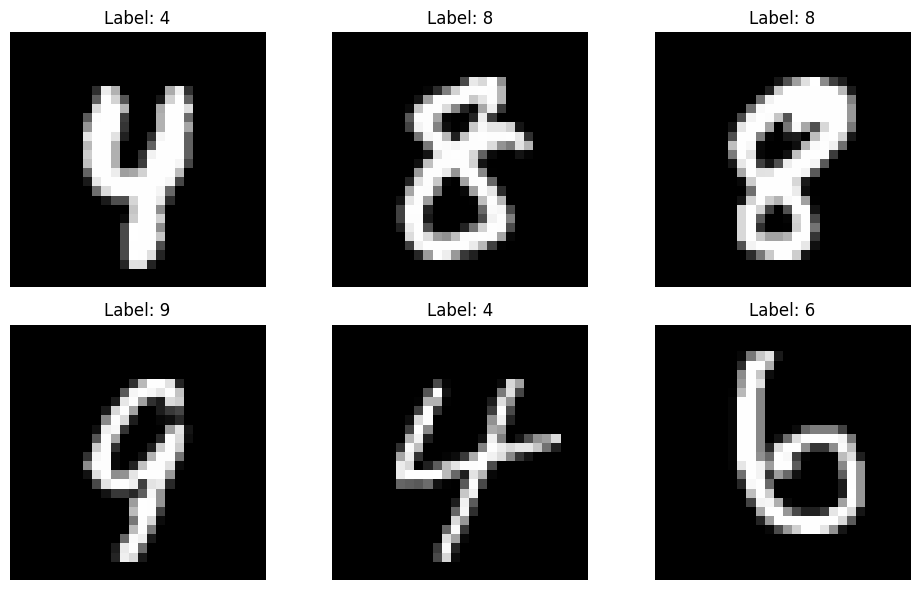

In [8]:
import matplotlib.pyplot as plt
print("sample of training data")
# Plot a few sample images from the training set
plt.figure(figsize=(10, 6))
for images, labels in train_loader:
    # Loop through the first few images in the batch
    for i in range(6):  # Display the first 6 images
        plt.subplot(2, 3, i + 1)
        # Convert the image to 2D by squeezing the channel dimension
        plt.imshow(images[i][0], cmap='gray')  
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    break  # Display only the first batch

plt.tight_layout()
plt.show()


In [9]:
inputsize = 784
hiddensize = [256,128,64]
numofclasses = 10
lr = 0.01

This code defines a custom neural network class in PyTorch, designed with configurable layers, activations, dropout, and batch normalization.
The neuralnetwork class inherits from torch.nn.Module and implements a fully connected feedforward neural network with ReLU activation, dropout, and batch normalization for better generalization and stability.
Parameters:
input_size: The number of features in the input data.
hidden_sizes: A list specifying the number of neurons in each hidden layer.
num_of_layers: The number of hidden layers in the network.
num_of_classes: The number of output classes for the classification task.
dropout_prob: (default=0.1): Dropout probability to reduce overfitting.

In [10]:
class neuralnetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_of_layers, num_of_classes, dropout_prob=0.1):
        super(neuralnetwork, self).__init__()

        # Validate number of layers and hidden sizes

        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=dropout_prob))

        # Hidden layers
        for i in range(1, num_of_layers):
            self.layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            self.layers.append(nn.BatchNorm1d(hidden_sizes[i]))  # Batch normalization
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_prob))

        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], num_of_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

instantiates the neuralnetwork

In [11]:
model = neuralnetwork(inputsize,hiddensize,3, numofclasses)

optimizer is responsible for updating the model's weights based on the computed gradients during backpropagation to minimize the loss function.
loss function to measures how far the model’s predictions are from the true labels.

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr)
lossfunction = nn.CrossEntropyLoss()

In [13]:
#training loop
def train_model(model, train_loader, val_loader, epochs, learning_rate):
    optimizer = torch.optim.SGD(model.parameters(), lr)
    lossfunction = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, correct_train = 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = lossfunction(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct_train += (outputs.argmax(dim=1) == labels).sum().item()

        # Validation
        model.eval()
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                val_loss += lossfunction(outputs, labels).item()
                correct_val += (outputs.argmax(dim=1) == labels).sum().item()

        # Store metrics
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(correct_train / len(train_loader.dataset))
        val_accuracies.append(correct_val / len(val_loader.dataset))

        print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, "
              f"Train Acc={train_accuracies[-1]:.4f}, Val Acc={val_accuracies[-1]:.4f}")
        

    return train_losses, val_losses, train_accuracies, val_accuracies

Loop iterates through the specified number of epochs
Set Model to Training Mode:
Forward Pass: Compute predictions from the model.
Backward Pass: Compute gradients of the loss with respect to model parameters.
Weight Update: Update model weights using the optimizer.
Train Metrics:
train_loss: Sum of training losses for the epoch.
correct_train: Count of correctly classified samples.
Set Model to Evaluation Mode:
Validation Metrics:
val_loss: Sum of validation losses for the epoch.
correct_val: Count of correctly classified validation samples.
Losses are normalized by the size of the data loaders.
Accuracies are calculated as the ratio of correctly classified samples to the dataset size.


In [14]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    learning_rate=lr
)



Epoch 1/20: Train Loss=0.6800, Val Loss=0.2505, Train Acc=0.8518, Val Acc=0.9390
Epoch 2/20: Train Loss=0.2543, Val Loss=0.1506, Train Acc=0.9374, Val Acc=0.9604
Epoch 3/20: Train Loss=0.1769, Val Loss=0.1194, Train Acc=0.9540, Val Acc=0.9657
Epoch 4/20: Train Loss=0.1383, Val Loss=0.1073, Train Acc=0.9631, Val Acc=0.9690
Epoch 5/20: Train Loss=0.1154, Val Loss=0.0959, Train Acc=0.9688, Val Acc=0.9718
Epoch 6/20: Train Loss=0.0965, Val Loss=0.0849, Train Acc=0.9745, Val Acc=0.9758
Epoch 7/20: Train Loss=0.0857, Val Loss=0.0787, Train Acc=0.9771, Val Acc=0.9762
Epoch 8/20: Train Loss=0.0763, Val Loss=0.0769, Train Acc=0.9792, Val Acc=0.9785
Epoch 9/20: Train Loss=0.0691, Val Loss=0.0754, Train Acc=0.9811, Val Acc=0.9782
Epoch 10/20: Train Loss=0.0644, Val Loss=0.0744, Train Acc=0.9813, Val Acc=0.9786
Epoch 11/20: Train Loss=0.0584, Val Loss=0.0705, Train Acc=0.9837, Val Acc=0.9794
Epoch 12/20: Train Loss=0.0516, Val Loss=0.0739, Train Acc=0.9857, Val Acc=0.9788
Epoch 13/20: Train Loss=0

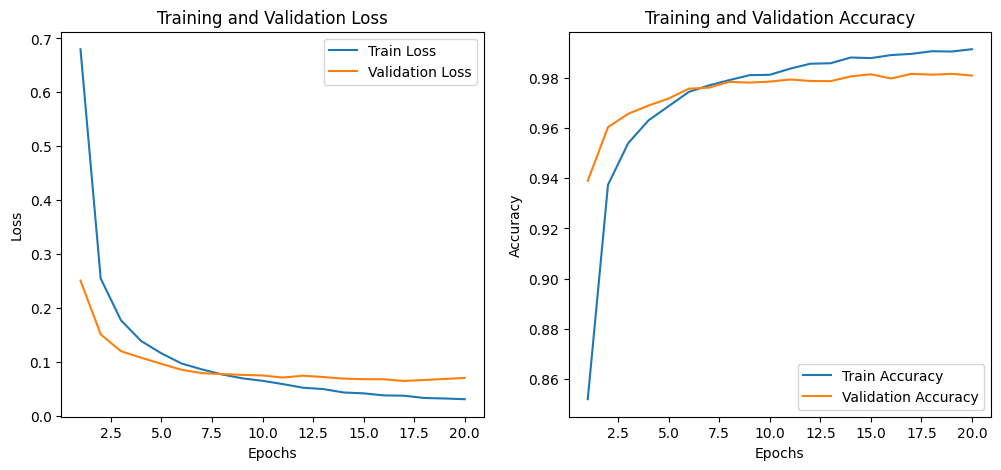

In [15]:
epochs = range(1, len(train_losses) + 1)

# Loss plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()


plt.show()

In [16]:
def test_model(model, test_loader, loss_fn):
    model.eval()
    correct_test, total_test, test_loss = 0, 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)
            y_true.extend(labels.tolist())
            y_pred.extend(preds.tolist())

    accuracy = (correct_test / total_test)*100
    print(f"Test Accuracy: {accuracy:}")
    return accuracy, y_true, y_pred
    

The test_model function evaluates a trained neural network on a test dataset, calculates the loss and accuracy, and provides true and predicted labels for further analysis.
No Gradient Calculation: torch.no_grad() prevents computation of gradients, saving memory and computation time.
Predictions: Obtain model predictions for each batch and calculate the loss.
Comparison: Compare predictions (preds) to true labels (labels) and count correct ones.
Tracking: Extend y_true and y_pred with labels and predictions for analysis

In [17]:
test_model(model, test_loader, lossfunction)

Test Accuracy: 98.19


(98.19,
 [7,
  2,
  1,
  0,
  4,
  1,
  4,
  9,
  5,
  9,
  0,
  6,
  9,
  0,
  1,
  5,
  9,
  7,
  3,
  4,
  9,
  6,
  6,
  5,
  4,
  0,
  7,
  4,
  0,
  1,
  3,
  1,
  3,
  4,
  7,
  2,
  7,
  1,
  2,
  1,
  1,
  7,
  4,
  2,
  3,
  5,
  1,
  2,
  4,
  4,
  6,
  3,
  5,
  5,
  6,
  0,
  4,
  1,
  9,
  5,
  7,
  8,
  9,
  3,
  7,
  4,
  6,
  4,
  3,
  0,
  7,
  0,
  2,
  9,
  1,
  7,
  3,
  2,
  9,
  7,
  7,
  6,
  2,
  7,
  8,
  4,
  7,
  3,
  6,
  1,
  3,
  6,
  9,
  3,
  1,
  4,
  1,
  7,
  6,
  9,
  6,
  0,
  5,
  4,
  9,
  9,
  2,
  1,
  9,
  4,
  8,
  7,
  3,
  9,
  7,
  4,
  4,
  4,
  9,
  2,
  5,
  4,
  7,
  6,
  7,
  9,
  0,
  5,
  8,
  5,
  6,
  6,
  5,
  7,
  8,
  1,
  0,
  1,
  6,
  4,
  6,
  7,
  3,
  1,
  7,
  1,
  8,
  2,
  0,
  2,
  9,
  9,
  5,
  5,
  1,
  5,
  6,
  0,
  3,
  4,
  4,
  6,
  5,
  4,
  6,
  5,
  4,
  5,
  1,
  4,
  4,
  7,
  2,
  3,
  2,
  7,
  1,
  8,
  1,
  8,
  1,
  8,
  5,
  0,
  8,
  9,
  2,
  5,
  0,
  1,
  1,
  1,
  0,
  9,
  0,
  3,
  1,
  6,
  

Learning Rate Selection
This section explores the effect of different learning rates on the performance of a neural network. The goal is to identify the optimal learning rate that provides the best validation accuracy.
best_lr: Stores the best learning rate.
best_val_acc: Tracks the highest validation accuracy achieved.
best_model: Keeps the model with the best validation performance.
metrics: Dictionary to store losses and accuracies for each learning rate
Initialize a new model, loss function, and optimizer for each learning rate.
Train the model using the train_model function for 10 epochs.
Store training and validation metrics for plotting.
Update the best model and learning rate if the validation accuracy improves.
Prints the learning rate that achieved the highest validation accuracy.
Loss Plot: Compares training and validation loss across epochs for each learning rate.
Accuracy Plot: Compares training and validation accuracy across epochs for each learning rate.


Learning Rate: 0.02
Epoch 1/10: Train Loss=0.4920, Val Loss=0.1771, Train Acc=0.8832, Val Acc=0.9534
Epoch 2/10: Train Loss=0.1845, Val Loss=0.1256, Train Acc=0.9497, Val Acc=0.9644
Epoch 3/10: Train Loss=0.1345, Val Loss=0.1020, Train Acc=0.9625, Val Acc=0.9712
Epoch 4/10: Train Loss=0.1085, Val Loss=0.0922, Train Acc=0.9688, Val Acc=0.9738
Epoch 5/10: Train Loss=0.0916, Val Loss=0.0831, Train Acc=0.9733, Val Acc=0.9752
Epoch 6/10: Train Loss=0.0785, Val Loss=0.0765, Train Acc=0.9765, Val Acc=0.9778
Epoch 7/10: Train Loss=0.0671, Val Loss=0.0800, Train Acc=0.9808, Val Acc=0.9761
Epoch 8/10: Train Loss=0.0598, Val Loss=0.0790, Train Acc=0.9816, Val Acc=0.9772
Epoch 9/10: Train Loss=0.0537, Val Loss=0.0744, Train Acc=0.9836, Val Acc=0.9794
Epoch 10/10: Train Loss=0.0490, Val Loss=0.0770, Train Acc=0.9855, Val Acc=0.9774

Learning Rate: 0.1
Epoch 1/10: Train Loss=0.2967, Val Loss=0.1181, Train Acc=0.9168, Val Acc=0.9667
Epoch 2/10: Train Loss=0.1422, Val Loss=0.1038, Train Acc=0.9579, V

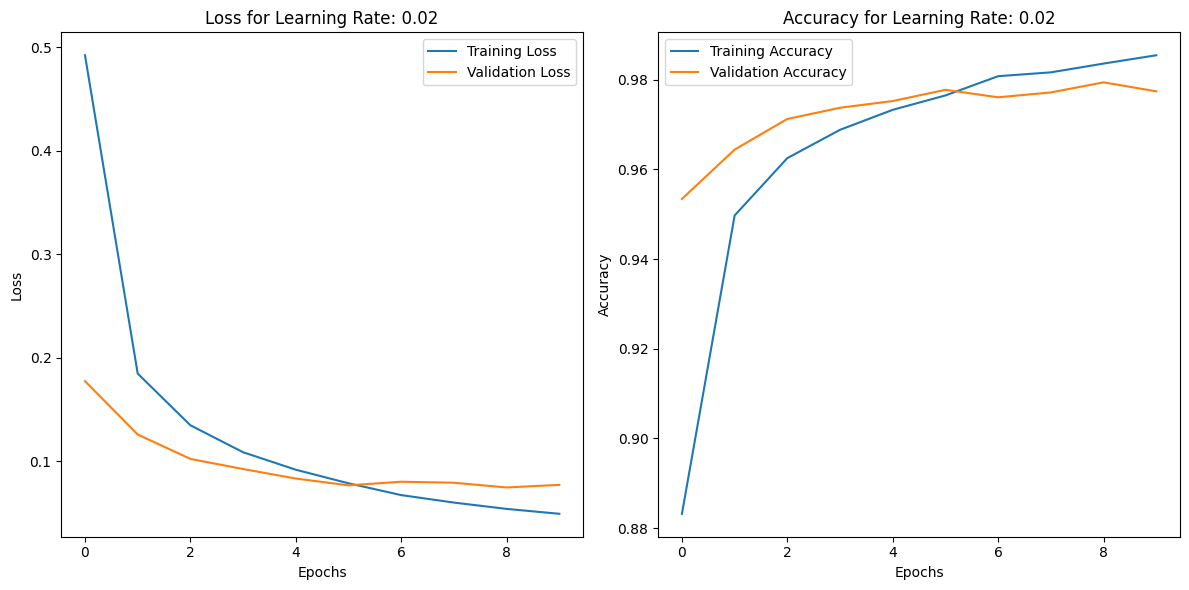

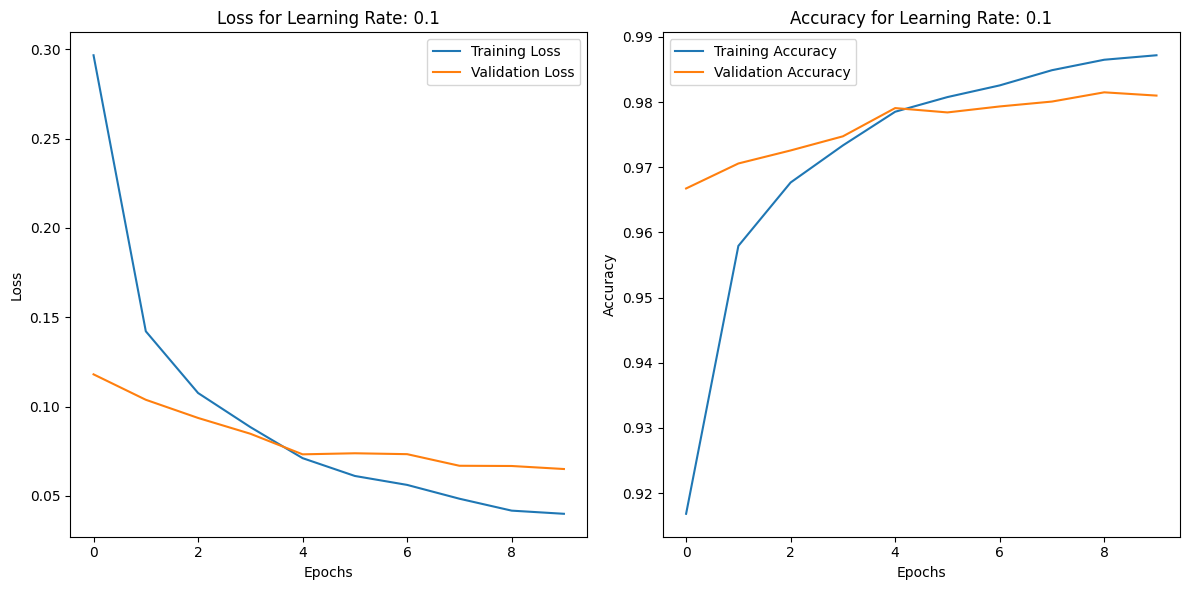

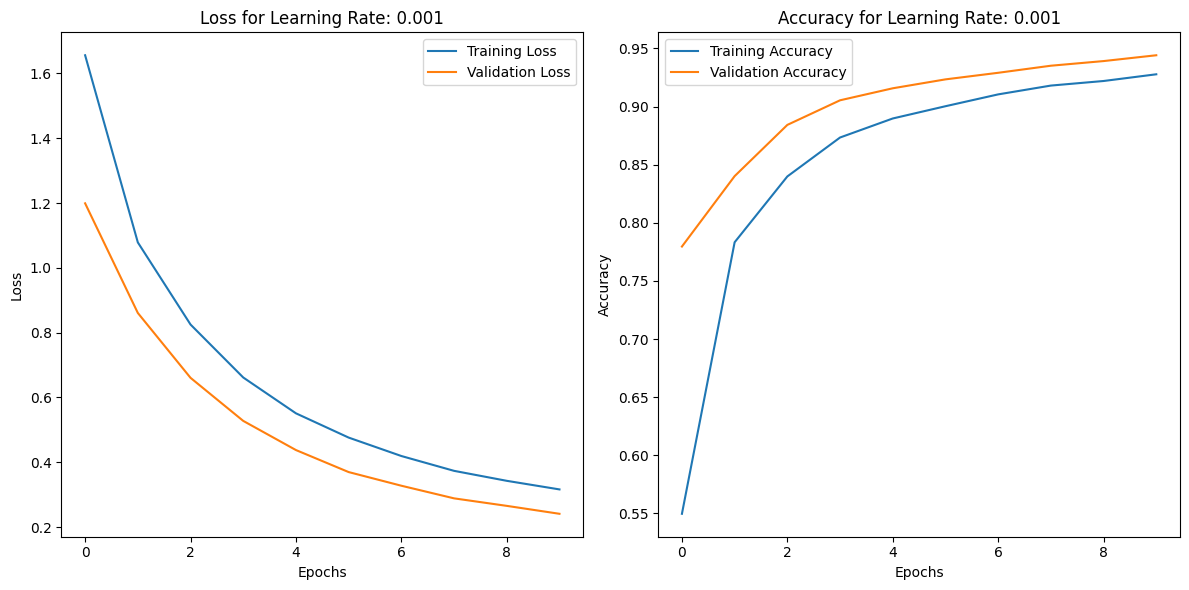

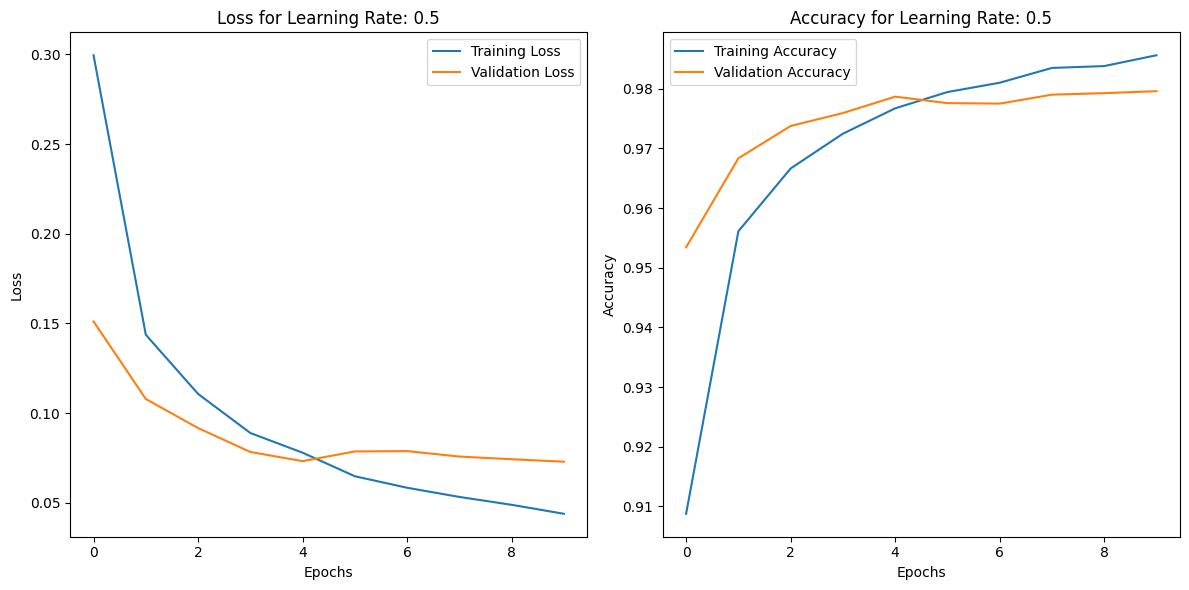

In [18]:

learning_rates = [0.02, 0.1, 0.001, 0.5]
best_lr = None
best_val_acc = 0.0
best_model = None

# Dictionary to store training/validation metrics for each learning rate
metrics = {}

for lr in learning_rates:
    # Initialize the model, loss function, and optimizer
    model = neuralnetwork(inputsize, hiddensize, 3, numofclasses)
    lossfunction = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    print(f"\nLearning Rate: {lr}")
    
    # Train and validate the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, epochs=10, learning_rate=lr
    )
    
    # Store for plotting
    metrics[lr] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }
    
    # Get the validation accuracy for the last epoch
    val_acc = val_accuracies[-1]
    
    # Save the best model and learning rate in memory
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_lr = lr
        best_model = model  # Keep the best model in memory

print(f"\nBest Learning Rate: {best_lr}, Best Validation Accuracy: {best_val_acc:.4f}")

# Plot training and validation losses/accuracies for each learning rate
for lr in learning_rates:
    plt.figure(figsize=(12, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(metrics[lr]["train_losses"], label="Training Loss")
    plt.plot(metrics[lr]["val_losses"], label="Validation Loss")
    plt.title(f"Loss for Learning Rate: {lr}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(metrics[lr]["train_accuracies"], label="Training Accuracy")
    plt.plot(metrics[lr]["val_accuracies"], label="Validation Accuracy")
    plt.title(f"Accuracy for Learning Rate: {lr}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()



In this section, we evaluate the impact of different batch sizes on the performance of our neural network. Batch size determines the number of samples processed before updating the model's weights. We test a range of batch sizes (16, 32, 64, 128) and train the model for 10 epochs using a fixed learning rate (0.01). For each batch size, we calculate training and validation losses and accuracies, storing the metrics for comparison. 
The batch size that achieves the highest validation accuracy is identified as the best.
Loss and accuracy curves are plotted for each batch size


Batch Size: 16
Epoch 1/10: Train Loss=0.3811, Val Loss=0.1511, Train Acc=0.8852, Val Acc=0.9561
Epoch 2/10: Train Loss=0.1964, Val Loss=0.1052, Train Acc=0.9417, Val Acc=0.9674
Epoch 3/10: Train Loss=0.1490, Val Loss=0.1030, Train Acc=0.9553, Val Acc=0.9695
Epoch 4/10: Train Loss=0.1299, Val Loss=0.0916, Train Acc=0.9607, Val Acc=0.9734
Epoch 5/10: Train Loss=0.1074, Val Loss=0.0847, Train Acc=0.9683, Val Acc=0.9755
Epoch 6/10: Train Loss=0.1001, Val Loss=0.0806, Train Acc=0.9685, Val Acc=0.9768
Epoch 7/10: Train Loss=0.0912, Val Loss=0.0767, Train Acc=0.9718, Val Acc=0.9780
Epoch 8/10: Train Loss=0.0794, Val Loss=0.0805, Train Acc=0.9751, Val Acc=0.9764
Epoch 9/10: Train Loss=0.0744, Val Loss=0.0801, Train Acc=0.9769, Val Acc=0.9792
Epoch 10/10: Train Loss=0.0680, Val Loss=0.0800, Train Acc=0.9790, Val Acc=0.9772

Batch Size: 32
Epoch 1/10: Train Loss=0.3241, Val Loss=0.1448, Train Acc=0.9024, Val Acc=0.9574
Epoch 2/10: Train Loss=0.1683, Val Loss=0.1101, Train Acc=0.9499, Val Acc=0.

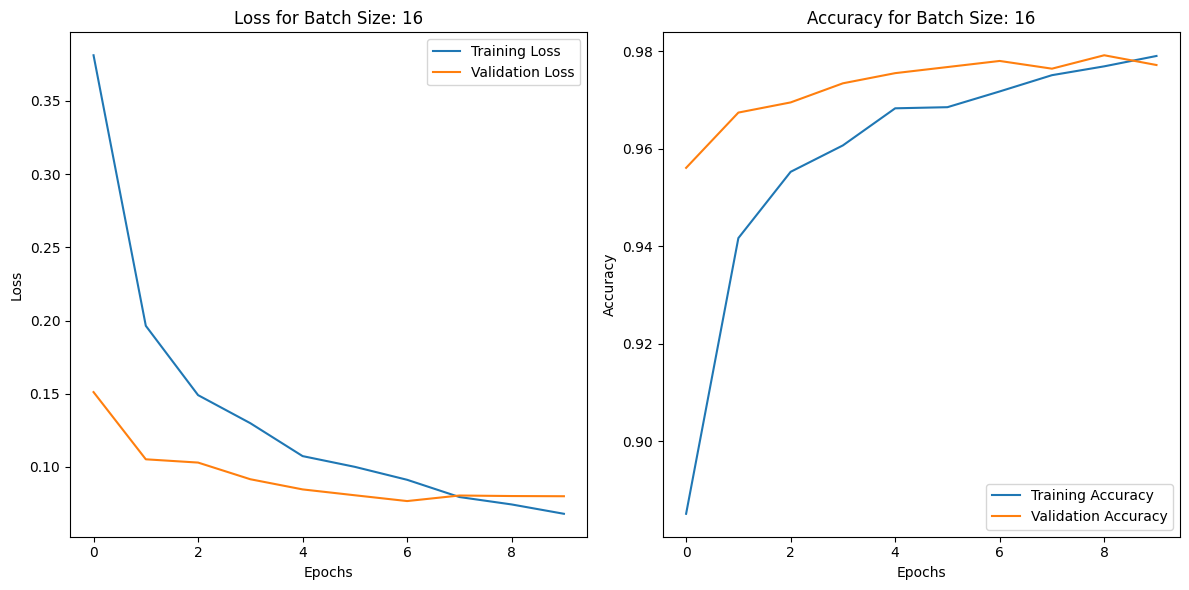

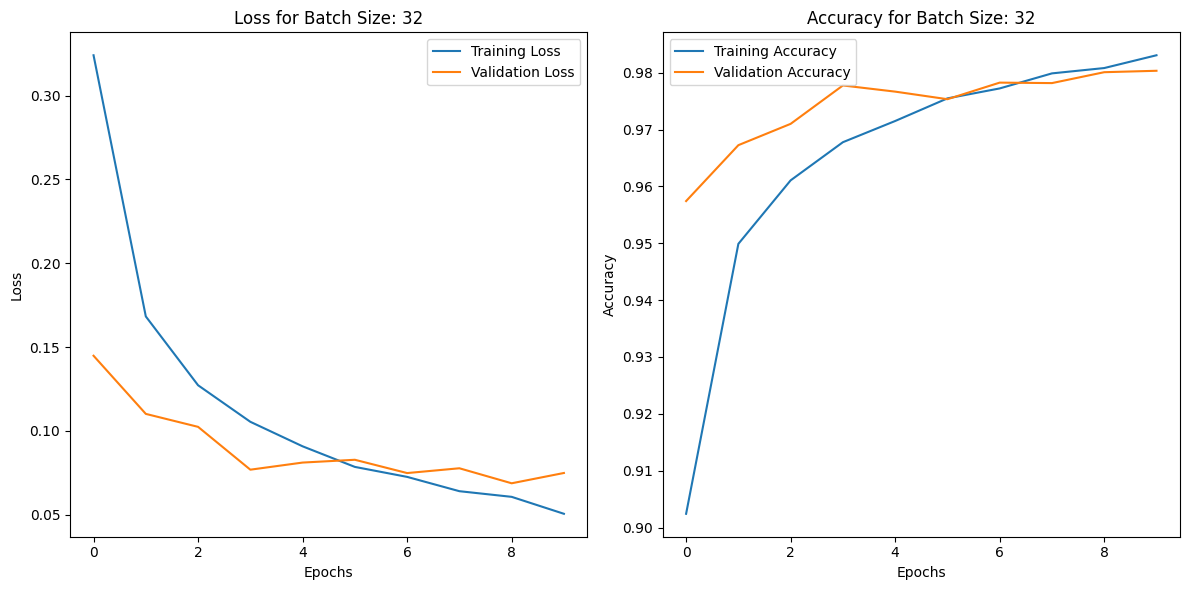

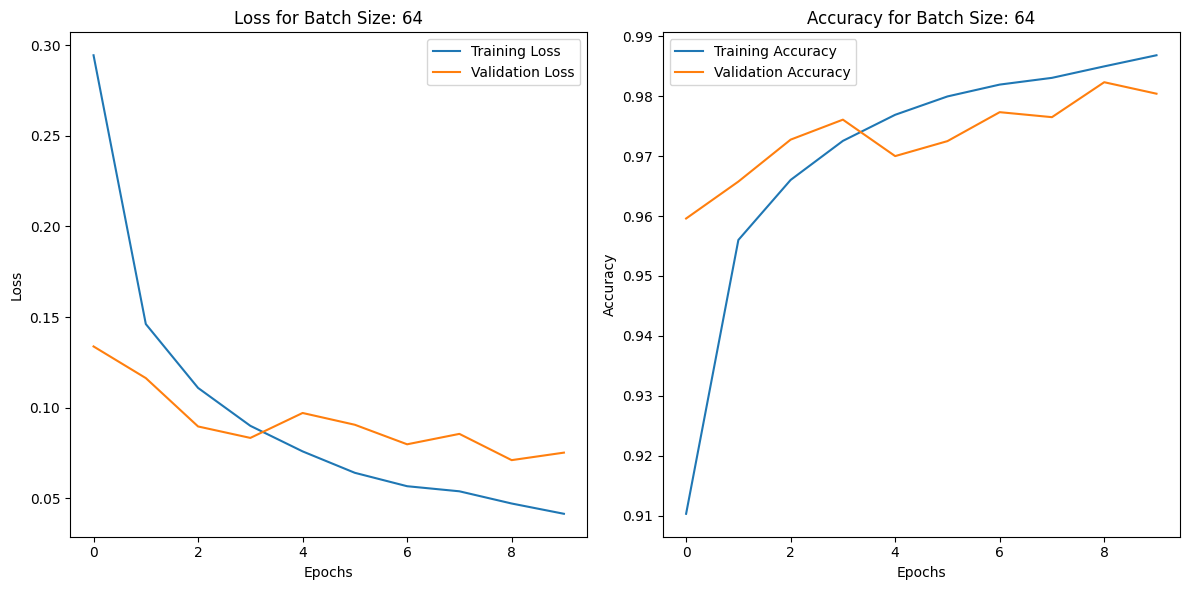

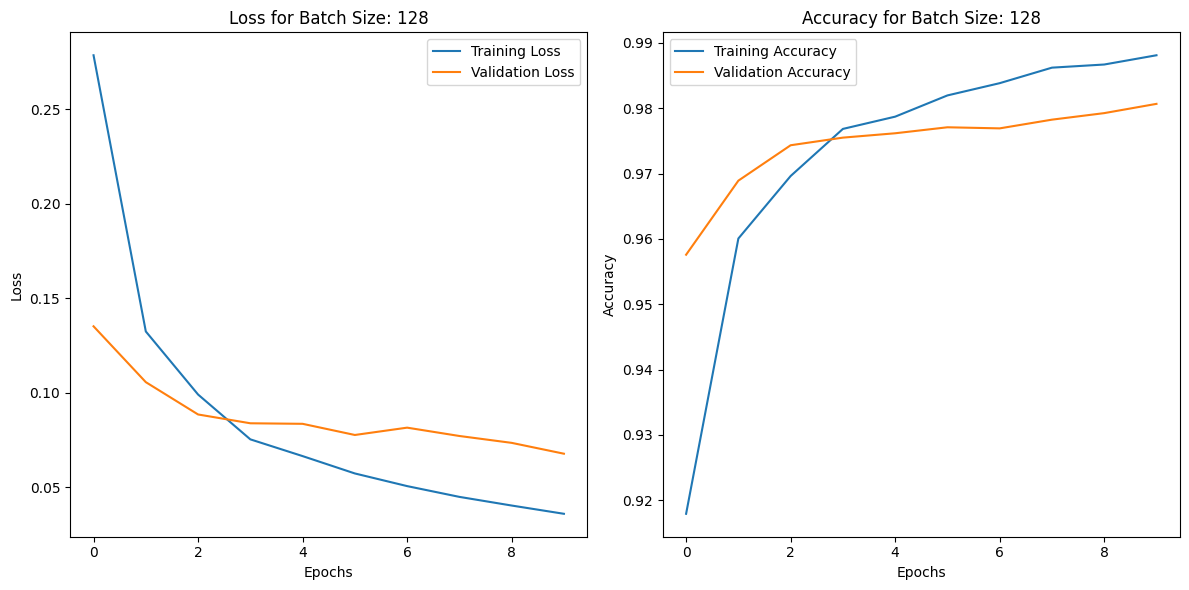

In [19]:
batch_sizes = [16, 32, 64, 128]  # Define batch sizes to test
best_batch_size = None
best_val_acc = 0.0
best_model = None

# Dictionary to store training/validation metrics for each batch size
metrics_batch_size = {}

for batch_size in batch_sizes:
    # Update the data loaders with the current batch size
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    # Initialize the model, loss function, and optimizer
    model = neuralnetwork(inputsize, hiddensize, 3, numofclasses)
    lossfunction = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Fixed learning rate for comparison
    
    print(f"\nBatch Size: {batch_size}")
    
    # Train and validate the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, epochs=10, learning_rate=0.01
    )
    
    # Store metrics for later plotting
    metrics_batch_size[batch_size] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }
    
    # Get the validation accuracy for the last epoch
    val_acc = val_accuracies[-1]
    
    # Save the best model and batch size in memory
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_batch_size = batch_size
        best_model = model  # Keep the best model in memory

print(f"\nBest Batch Size: {best_batch_size}, Best Validation Accuracy: {best_val_acc:.4f}")

# Plot training and validation losses/accuracies for each batch size
for batch_size in batch_sizes:
    plt.figure(figsize=(12, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(metrics_batch_size[batch_size]["train_losses"], label="Training Loss")
    plt.plot(metrics_batch_size[batch_size]["val_losses"], label="Validation Loss")
    plt.title(f"Loss for Batch Size: {batch_size}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(metrics_batch_size[batch_size]["train_accuracies"], label="Training Accuracy")
    plt.plot(metrics_batch_size[batch_size]["val_accuracies"], label="Validation Accuracy")
    plt.title(f"Accuracy for Batch Size: {batch_size}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In this step, we test different hidden layer sizes to determine the best architecture for our neural network. Each size specifies the number of neurons in the hidden layers, and we evaluate the model's performance using [256, 128, 64], [256, 128, 128], [512, 256, 128], and [512, 128, 64]. The model is trained for 10 epochs with a fixed learning rate of 0.01.

For each size, training and validation losses and accuracies are tracked. The hidden layer size that achieves the highest validation accuracy is selected as the best. Loss and accuracy curves for each size are plotted to visualize the training and validation performance


Hidden Layer Size: [256, 128, 64]
Epoch 1/10: Train Loss=0.2808, Val Loss=0.1403, Train Acc=0.9147, Val Acc=0.9568
Epoch 2/10: Train Loss=0.1347, Val Loss=0.0957, Train Acc=0.9595, Val Acc=0.9716
Epoch 3/10: Train Loss=0.0982, Val Loss=0.0939, Train Acc=0.9692, Val Acc=0.9711
Epoch 4/10: Train Loss=0.0808, Val Loss=0.0838, Train Acc=0.9743, Val Acc=0.9754
Epoch 5/10: Train Loss=0.0674, Val Loss=0.0858, Train Acc=0.9787, Val Acc=0.9756
Epoch 6/10: Train Loss=0.0577, Val Loss=0.0772, Train Acc=0.9817, Val Acc=0.9780
Epoch 7/10: Train Loss=0.0511, Val Loss=0.0734, Train Acc=0.9833, Val Acc=0.9792
Epoch 8/10: Train Loss=0.0467, Val Loss=0.0703, Train Acc=0.9851, Val Acc=0.9799
Epoch 9/10: Train Loss=0.0383, Val Loss=0.0673, Train Acc=0.9869, Val Acc=0.9812
Epoch 10/10: Train Loss=0.0359, Val Loss=0.0780, Train Acc=0.9886, Val Acc=0.9803

Hidden Layer Size: [256, 128, 128]
Epoch 1/10: Train Loss=0.2744, Val Loss=0.1413, Train Acc=0.9153, Val Acc=0.9549
Epoch 2/10: Train Loss=0.1313, Val Lo

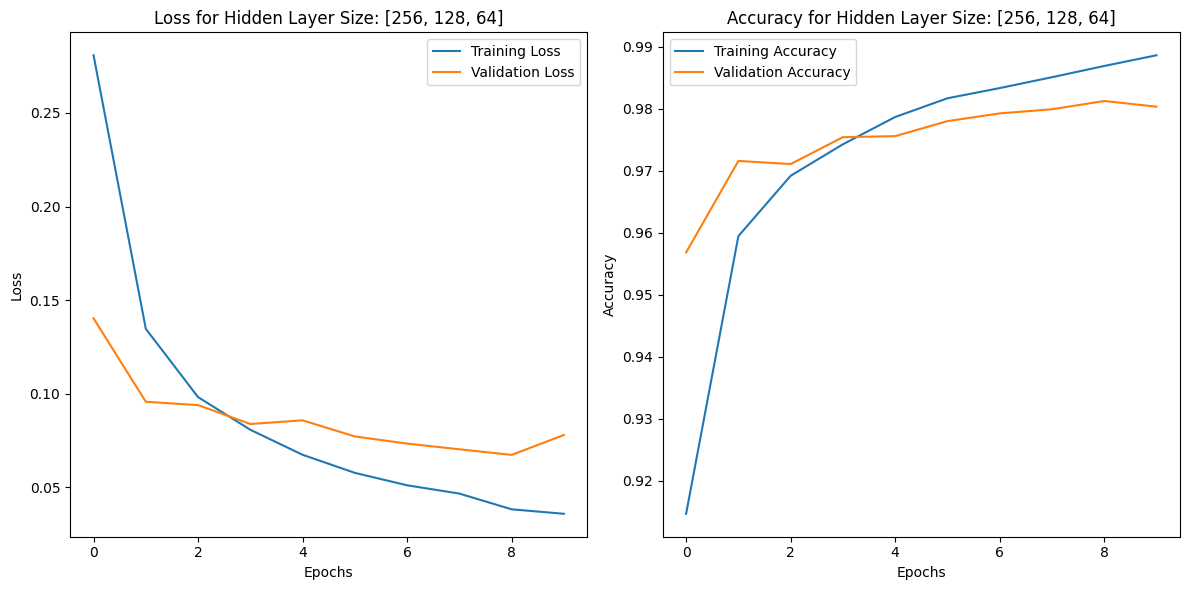

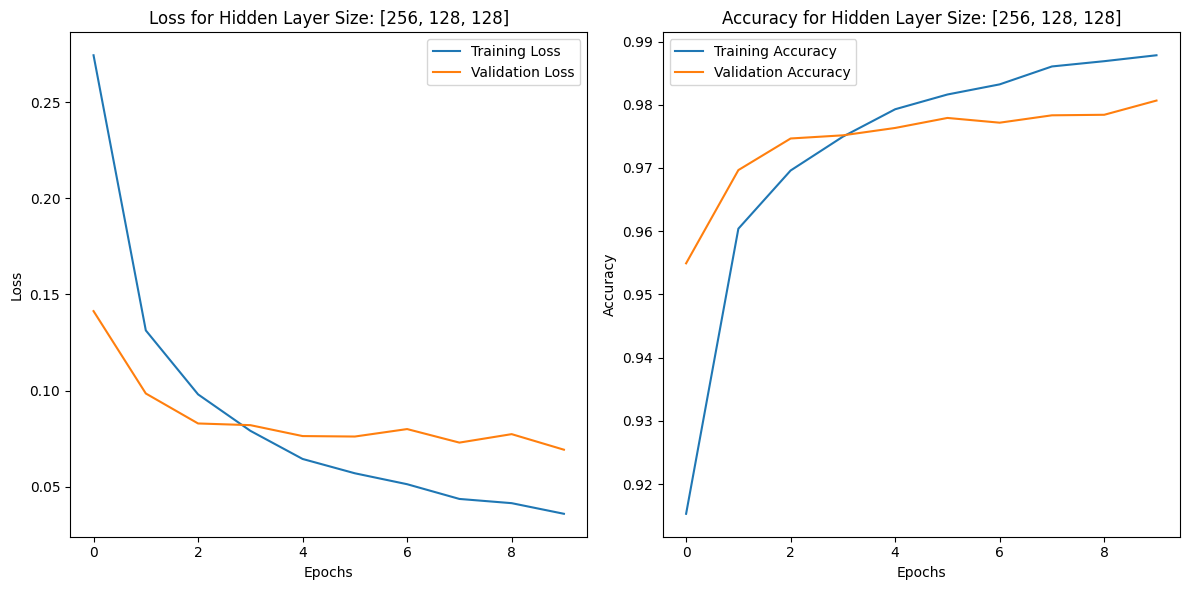

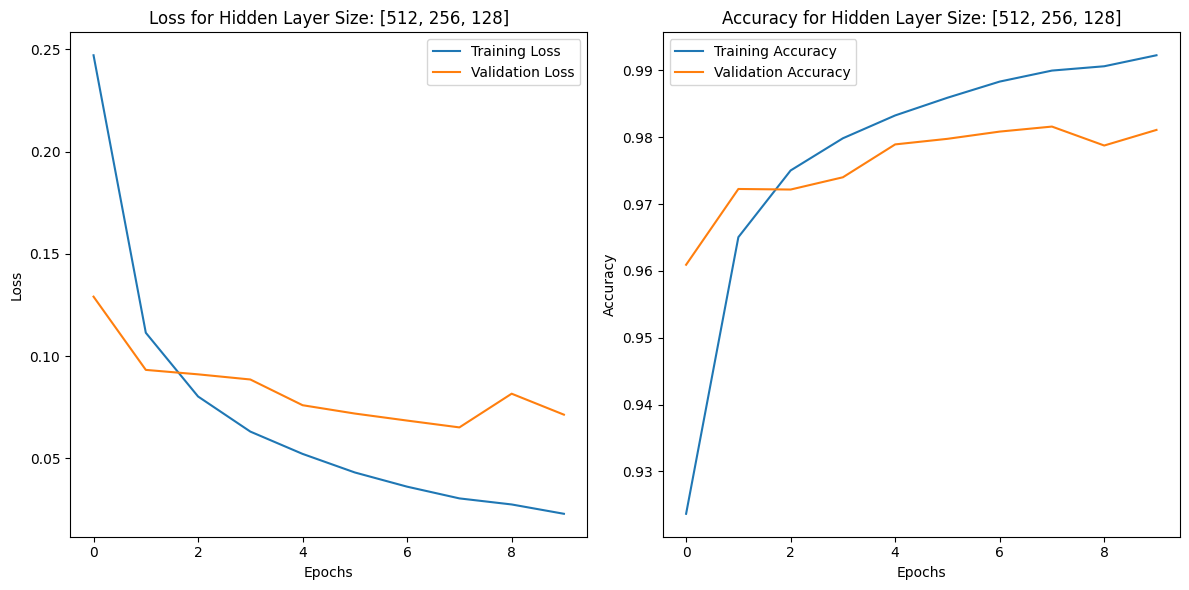

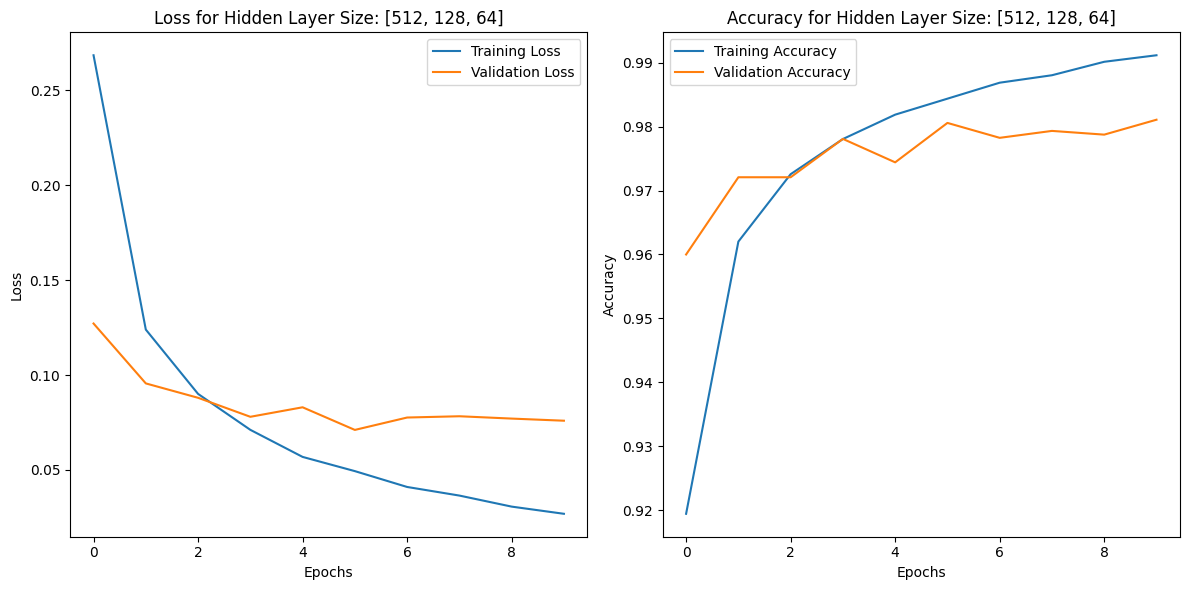

In [20]:
hidden_sizes = [[256, 128, 64], [256, 128, 128], [512, 256, 128], [512, 128, 64]]  # Define different numbers of neurons to test
best_hidden_size = None
best_val_acc = 0.0
best_model = None

# Dictionary to store training/validation metrics for each hidden layer size
metrics_hidden_size = {}

for hidden_size in hidden_sizes:
    # Initialize the model, loss function, and optimizer
    model = neuralnetwork(inputsize, hidden_size, 3, numofclasses)  # Fixed hidden layers no
    lossfunction = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Fixed learning rate for comparison
    
    print(f"\nHidden Layer Size: {hidden_size}")
    
    # Train and validate the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, epochs=10, learning_rate=0.01
    )
    
    # Store metrics for later plotting, using tuple of hidden_size as the key
    metrics_hidden_size[tuple(hidden_size)] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }
    
    # Get the validation accuracy for the last epoch
    val_acc = val_accuracies[-1]
    
    # Save the best model and hidden size in memory
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_hidden_size = hidden_size
        best_model = model  # Keep the best model in memory

print(f"\nBest Hidden Layer Size: {best_hidden_size}, Best Validation Accuracy: {best_val_acc:.4f}")

# Plot training and validation losses/accuracies for each hidden layer size
for hidden_size in hidden_sizes:
    plt.figure(figsize=(12, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(metrics_hidden_size[tuple(hidden_size)]["train_losses"], label="Training Loss")
    plt.plot(metrics_hidden_size[tuple(hidden_size)]["val_losses"], label="Validation Loss")
    plt.title(f"Loss for Hidden Layer Size: {hidden_size}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(metrics_hidden_size[tuple(hidden_size)]["train_accuracies"], label="Training Accuracy")
    plt.plot(metrics_hidden_size[tuple(hidden_size)]["val_accuracies"], label="Validation Accuracy")
    plt.title(f"Accuracy for Hidden Layer Size: {hidden_size}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In this step we assess the performance of the neural network using different numbers of hidden layers to identify the best number. The tested architectures include:

Three Hidden Layers: [256, 128, 64]
Four Hidden Layers: [512, 256, 128, 64]
Five Hidden Layers: [512, 256, 256, 128, 64]
Six Hidden Layers: [512, 256, 128, 128, 64, 64]
Each number of layer is trained for 10 epochs with a fixed learning rate of 0.01, and the validation accuracy at the final epoch is used to determine the best-performing architecture. For each number, we track and plot training and validation losses and accuracies, providing insights into how the number of hidden layers affects the model's learning process.



Hidden Layer : [256, 128, 64]
Epoch 1/10: Train Loss=0.2828, Val Loss=0.1394, Train Acc=0.9144, Val Acc=0.9570
Epoch 2/10: Train Loss=0.1358, Val Loss=0.1092, Train Acc=0.9602, Val Acc=0.9672
Epoch 3/10: Train Loss=0.1033, Val Loss=0.0911, Train Acc=0.9684, Val Acc=0.9711
Epoch 4/10: Train Loss=0.0780, Val Loss=0.0835, Train Acc=0.9760, Val Acc=0.9771
Epoch 5/10: Train Loss=0.0685, Val Loss=0.0859, Train Acc=0.9785, Val Acc=0.9747
Epoch 6/10: Train Loss=0.0592, Val Loss=0.0842, Train Acc=0.9814, Val Acc=0.9747
Epoch 7/10: Train Loss=0.0512, Val Loss=0.0791, Train Acc=0.9834, Val Acc=0.9776
Epoch 8/10: Train Loss=0.0474, Val Loss=0.0690, Train Acc=0.9848, Val Acc=0.9809
Epoch 9/10: Train Loss=0.0403, Val Loss=0.0763, Train Acc=0.9869, Val Acc=0.9791
Epoch 10/10: Train Loss=0.0344, Val Loss=0.0743, Train Acc=0.9884, Val Acc=0.9798

Hidden Layer : [512, 256, 128, 64]
Epoch 1/10: Train Loss=0.2803, Val Loss=0.1278, Train Acc=0.9162, Val Acc=0.9623
Epoch 2/10: Train Loss=0.1306, Val Loss=0

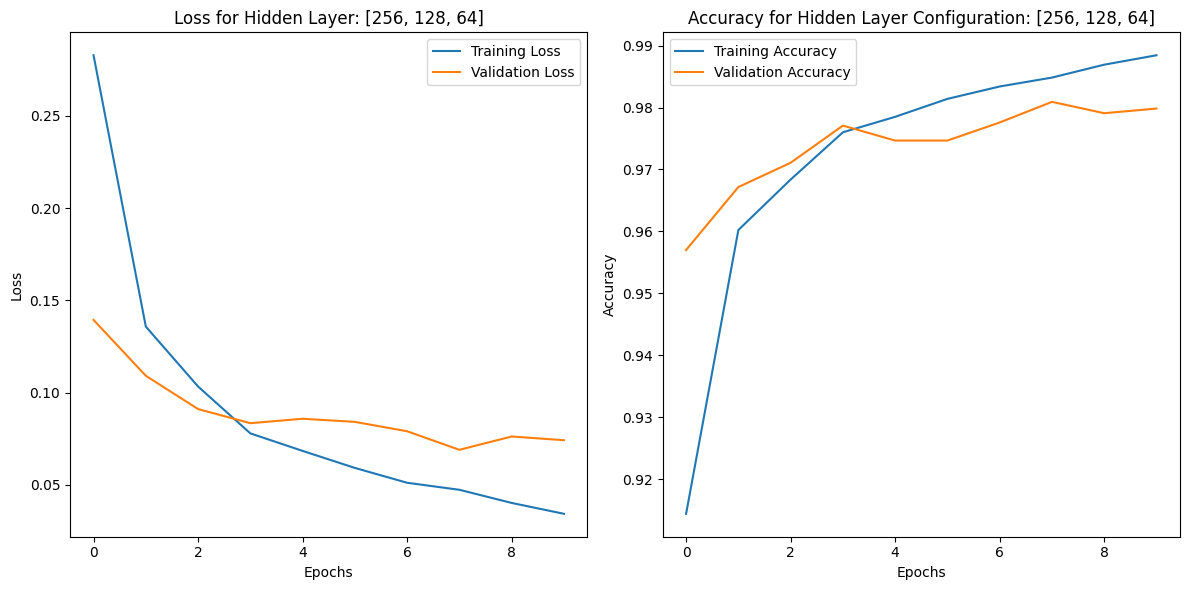

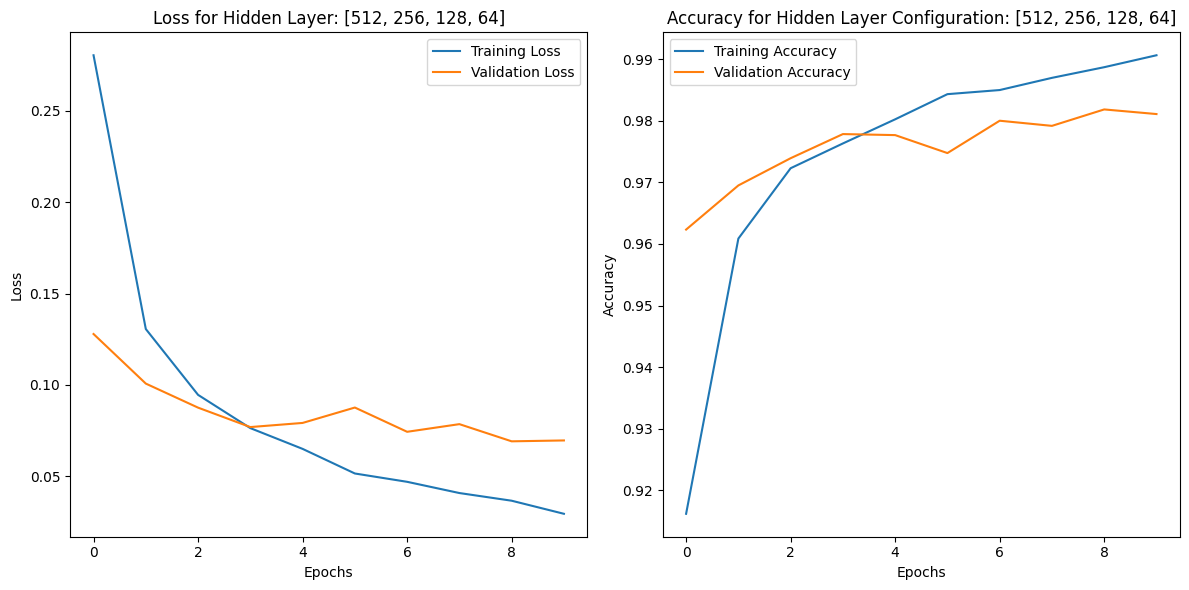

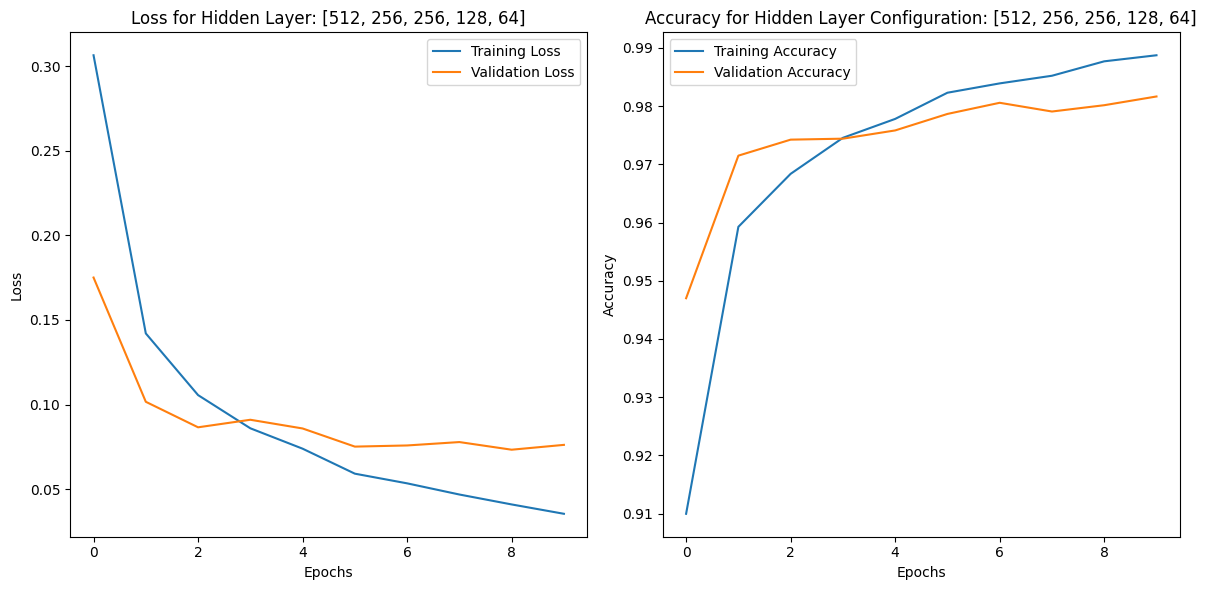

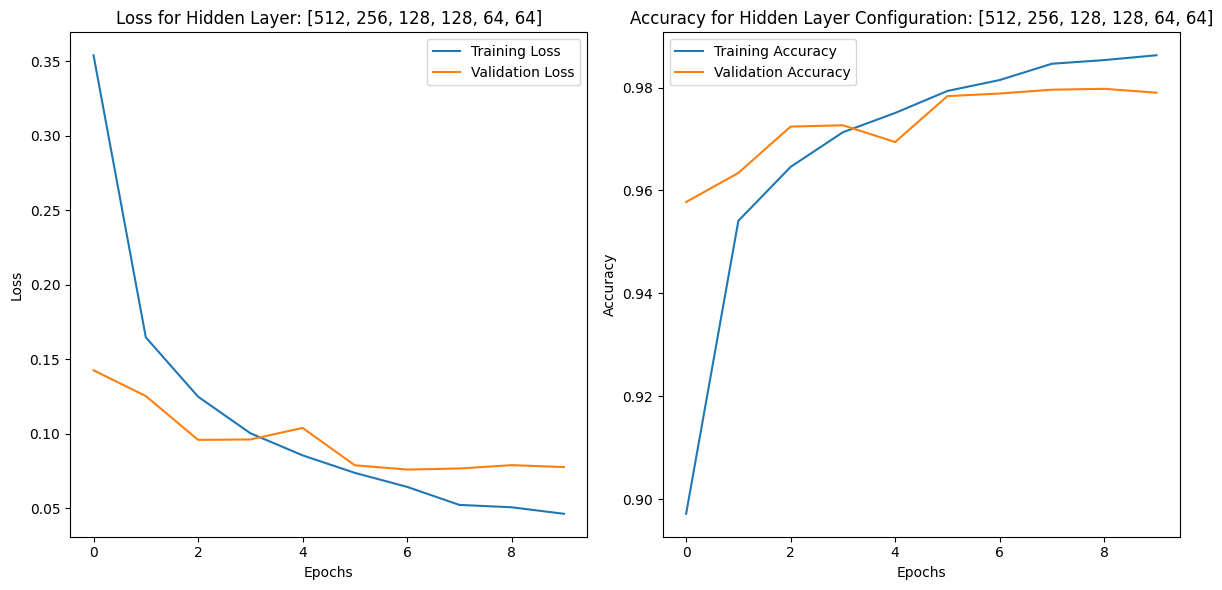

In [ ]:
# Define the different number of layer to test
layer_number = [
    [256,128,64],                # Three hidden layer
    [512, 256, 128, 64],           # Four hidden layers
    [512, 256, 256, 128,64],      # Five hidden layers
    [512, 256, 128, 128, 64,64]  # Six hidden layers
]

best_layers = None
best_val_acc = 0.0
best_model = None

# Dictionary to store training/validation metrics for each configuration
metrics_layers = {}
n = 3
for hidden_layers in layer_number:
    # Initialize the model, loss function, and optimizer
    model = neuralnetwork(inputsize, hidden_layers, n, numofclasses)  # Pass hidden_layers as the architecture
    lossfunction = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Fixed learning rate for comparison
    
    print(f"\nHidden Layer : {hidden_layers}")
    
    # Train and validate the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, epochs=10, learning_rate=0.01
    )
    
    # Store metrics for later plotting
    metrics_layers[tuple(hidden_layers)] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }
    
    # Get the validation accuracy for the last epoch
    val_acc = val_accuracies[-1]
    
    # Save the best model and configuration in memory
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_layers = hidden_layers
        best_model = model  # Keep the best model in memory
    n = n + 1

print(f"\nBest Hidden Layer : {best_layers}, Best Validation Accuracy: {best_val_acc:.4f}")

# Plot training and validation losses/accuracies for each hidden layer configuration
for hidden_layers in layer_number:
    plt.figure(figsize=(12, 6))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(metrics_layers[tuple(hidden_layers)]["train_losses"], label="Training Loss")
    plt.plot(metrics_layers[tuple(hidden_layers)]["val_losses"], label="Validation Loss")
    plt.title(f"Loss for Hidden Layer: {hidden_layers}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(metrics_layers[tuple(hidden_layers)]["train_accuracies"], label="Training Accuracy")
    plt.plot(metrics_layers[tuple(hidden_layers)]["val_accuracies"], label="Validation Accuracy")
    plt.title(f"Accuracy for Hidden Layer Configuration: {hidden_layers}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


here, we make another model wich is best after all the analysis we do in the previous stpes
using best learning rate,batch size, hidden size, and number of hidden layers
we first train best model then test the best model on test set 
report accuracy and confusion matrix	

In [26]:
#best model
besthidden = [512, 256, 128, 64]
bestmodel = neuralnetwork(inputsize, besthidden, 4,numofclasses,0.1)


In [27]:
best_train_loader=torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
best_val_loader=torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
best_test_loader=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=bestmodel,
    train_loader=best_train_loader,
    val_loader=best_val_loader,
    epochs=20,
    learning_rate=best_lr
)

Epoch 1/20: Train Loss=0.2820, Val Loss=0.1255, Train Acc=0.9149, Val Acc=0.9618
Epoch 2/20: Train Loss=0.1324, Val Loss=0.1150, Train Acc=0.9601, Val Acc=0.9663
Epoch 3/20: Train Loss=0.0951, Val Loss=0.0830, Train Acc=0.9716, Val Acc=0.9747
Epoch 4/20: Train Loss=0.0770, Val Loss=0.0951, Train Acc=0.9762, Val Acc=0.9737
Epoch 5/20: Train Loss=0.0621, Val Loss=0.0743, Train Acc=0.9810, Val Acc=0.9788
Epoch 6/20: Train Loss=0.0523, Val Loss=0.0739, Train Acc=0.9835, Val Acc=0.9797
Epoch 7/20: Train Loss=0.0451, Val Loss=0.0737, Train Acc=0.9851, Val Acc=0.9794
Epoch 8/20: Train Loss=0.0398, Val Loss=0.0733, Train Acc=0.9870, Val Acc=0.9792
Epoch 9/20: Train Loss=0.0363, Val Loss=0.0733, Train Acc=0.9885, Val Acc=0.9818
Epoch 10/20: Train Loss=0.0300, Val Loss=0.0709, Train Acc=0.9902, Val Acc=0.9814
Epoch 11/20: Train Loss=0.0284, Val Loss=0.0732, Train Acc=0.9911, Val Acc=0.9818
Epoch 12/20: Train Loss=0.0240, Val Loss=0.0767, Train Acc=0.9922, Val Acc=0.9804
Epoch 13/20: Train Loss=0

Test Accuracy: 98.42999999999999


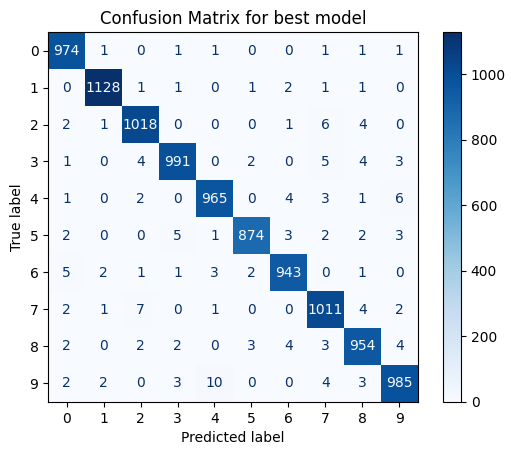

In [29]:
# Use the best model for testing or further evaluation
best_test_accuracy, best_y_true, best_y_pred = test_model(bestmodel, best_test_loader, lossfunction)
confmatrix = confusion_matrix(best_y_true, best_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confmatrix, display_labels=range(numofclasses))
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for best model")
plt.show()